In [ ]:
######################################################
### 2019 - 2020 Maritime Trade with COVID for LSTM ###
######################################################

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Data_MaritimeTrade/

/content/drive/MyDrive/Data_MaritimeTrade


In [3]:
!pip install category_encoders

In [4]:
import os
import pandas as pd
import numpy as np
import category_encoders as ce
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint
from math import sqrt
from numpy import concatenate
import matplotlib as plt
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
tf.random.set_seed(42)

In [6]:
df = pd.read_csv('combined_trade_final_LSTM.csv',low_memory=False)
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6633785, 20)


In [7]:
def data_quality_table(df):
        mis_val = df.isnull().sum()
        #mis_val = df.isnull().sum().loc[lambda x : x>0] 
        #mis_val = df.loc[:, df.isna().any()].isna().sum()
        var_type = df.dtypes
        unique_count = df.nunique()
        mis_val_table = pd.concat([mis_val, var_type, unique_count], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Number Missing', 1 : 'Data Type', 2 : 'Number Unique'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        'Number Missing', ascending=False).round(1)
        print ("The selected dataframe has " + str(df.shape[1]) + " columns.\n")
        return mis_val_table_ren_columns

pd.set_option('display.max_columns', None)
print("\nData Quality Report") 
print(data_quality_table(df))


Data Quality Report
The selected dataframe has 20 columns.

                        Number Missing Data Type  Number Unique
Container_LCL/FCL                    0    object              2
Metric_Tons                          0   float64          24994
deaths_pctdelta                      0   float64           1034
cases_pctdelta                       0   float64           1103
State_Closure_EA_Diff                0     int64              7
deaths_weekly                        0   float64           1034
cases_weekly                         0   float64           1104
Average_Tariff                       0   float64            631
US_Unemployment_Rate                 0   float64             14
HS_Group_Name                        0    object              6
Foreign_Country_Region               0    object             11
US_Port_Coastal_Region               0    object              6
foreign_company_size                 0    object              6
us_company_size                      0    o

In [8]:
# Convert dtypes
df = df.copy()
df['State_Closure_EA_Diff'] = df['State_Closure_EA_Diff'].astype('float64')
df['Container_Type_Dry'] = df['Container_Type_Dry'].astype('object')

In [9]:
# Convert 
df = df.copy()
df['DateTime']= pd.to_datetime(df['DateTime']) 
df['DateTime_YearWeek'] = df['DateTime'].dt.strftime('%Y-w%U')

In [10]:
df = df.drop(['DateTime'], axis=1)

In [11]:
# Reformat for X,y
df2 = df.drop(['Metric_Tons'], axis=1)
df1 = df.loc[:, ['Metric_Tons']]
df = pd.concat([df1, df2], axis=1)

del df1, df2

In [12]:
# Sort data chronologically
df = df.sort_values('DateTime_YearWeek')

In [13]:
# Set YearWeek in the index
df = df.set_index('DateTime_YearWeek')
df.head()

,Metric_Tons,Container_LCL/FCL,Container_Type_Dry,TCVUSD,Trade_Direction,Year,us_company_size,foreign_company_size,US_Port_Coastal_Region,Foreign_Country_Region,HS_Group_Name,US_Unemployment_Rate,Average_Tariff,cases_weekly,deaths_weekly,State_Closure_EA_Diff,cases_pctdelta,deaths_pctdelta,Delta_Case0_Effective
DateTime_YearWeek,,,,,,,,,,,,,,,,,,,
2019-w00,0.07,LCL,True,817.95,Import,2019,medium,small,Northeast,European Union,Finished Goods,4.0,6.19,0.0,0.0,2.0,0.0,0.0,27.0
2019-w00,11.54,FCL,True,68439.12,Import,2019,small,small,Southeast,China,Finished Goods,4.0,12.37,0.0,0.0,1.0,0.0,0.0,39.0
2019-w00,6.32,FCL,True,37481.39,Import,2019,small,small,Southeast,China,Finished Goods,4.0,12.37,0.0,0.0,1.0,0.0,0.0,39.0
2019-w00,3.82,FCL,True,22654.89,Import,2019,medium,small,Southeast,China,Finished Goods,4.0,12.37,0.0,0.0,1.0,0.0,0.0,39.0
2019-w00,4.15,FCL,True,24611.99,Import,2019,medium,small,Southeast,China,Finished Goods,4.0,12.37,0.0,0.0,1.0,0.0,0.0,39.0


In [14]:
# X,y for encoding
X = df.iloc[:,:-1]
y = df.iloc[:,:1]
print(X.shape)
print(y.shape)

(6633785, 18)
(6633785, 1)


In [15]:
# Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'us_company_size'])
result = ce_ord.fit_transform(X, y['Metric_Tons'])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [16]:
# Convert remaining qualitative vars to dummy vars
result = pd.get_dummies(result, prefix=['HS_Group_Name', 'Container_LCL/FCL', 'Foreign_Country_Region', 'US_Port_Coastal_Region', 'Trade_Direction', 'Container_Type_Dry'],
                      columns=['HS_Group_Name', 'Container_LCL/FCL', 'Foreign_Country_Region', 'US_Port_Coastal_Region', 'Trade_Direction', 'Container_Type_Dry'])
#currently 41
print(result.shape)

(6633785, 41)


In [17]:
df = result
print("\nData Quality Report") 
print(data_quality_table(df))
df.shape


Data Quality Report
The selected dataframe has 41 columns.

                                                    Number Missing Data Type  \
Metric_Tons                                                      0   float64   
Foreign_Country_Region_European Union                            0     uint8   
Foreign_Country_Region_North America                             0     uint8   
Foreign_Country_Region_Oceania                                   0     uint8   
Foreign_Country_Region_Other East Asia (not China)               0     uint8   
Foreign_Country_Region_Other Europe (not Europe...               0     uint8   
Foreign_Country_Region_South America                             0     uint8   
Foreign_Country_Region_South Asia                                0     uint8   
Foreign_Country_Region_Southeast Asia                            0     uint8   
Foreign_Country_Region_Sub Saharan Africa                        0     uint8   
US_Port_Coastal_Region_Gulf                                

(6633785, 41)

In [18]:
# Examine year for the number per year to be used for train/test sets
df[['Year']].value_counts()

Year
2019    3368492
2020    3265293
dtype: int64

In [19]:
df = df.drop(['Year'], axis=1)
df.shape

(6633785, 40)

In [20]:
# Prepare data for LSTM
# COnvert series to supervised learning
def series_to_supervised(dat, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(dat) is list else dat.shape[1]
	df = DataFrame(dat)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Load df
dataset = df
values = dataset.values
# Convert all data to float
values = values.astype('float32')
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)     var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000280  5.305452e-07        0.0        0.0   0.044248   0.003732   
2   0.046162  4.439152e-05        0.2        0.0   0.044248   0.007459   
3   0.025281  2.431148e-05        0.2        0.0   0.044248   0.007459   
4   0.015281  1.469459e-05        0.0        0.0   0.044248   0.007459   
5   0.016601  1.596402e-05        0.0        0.0   0.044248   0.007459   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1        0.0        0.0     0.1250         0.0    0.000004         0.0   
2        0.0        0.0     0.0625         0.0    0.000004         0.0   
3        0.0        0.0     0.0625         0.0    0.000004         0.0   
4        0.0        0.0     0.0625         0.0    0.000004         0.0   
5        0.0        0.0     0.0625         0.0    0.000004         0.0   

   var13(t-1)  var14(t-1)  var15(t-1)  var16(t-1)  var17(t-1)  var18(t-1)  \
1         0.0         1.0        

In [21]:
# Define fit model for 2019
# Split into train and test sets
values = reframed.values
n_train_hours = 3368492
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3368492, 1, 40) (3368492,) (3265292, 1, 40) (3265292,)


In [22]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.5.0
Eager execution is: True
Keras version: 2.5.0
Num GPUs Available:  1


In [23]:
# LSTM Model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', metrics=['mse'], optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                18200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [24]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

In [25]:
filepath = 'weights_only_train2019_test2020_n50_b64_epochs20'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mse', 
                                  save_best_only=True, mode='min'), 
                  tensorboard_callback]

In [27]:
# Best model for training 2019 = batch size 64, epochs 20, no cross val
history = model.fit(train_X, train_y, epochs=20, batch_size=64, shuffle=False, 
                    callbacks=callbacks_list)

Epoch 1/20
52633/52633 [==============================] - 170s 3ms/step - loss: 0.0580 - mse: 0.0157


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 2/20
52633/52633 [==============================] - 155s 3ms/step - loss: 0.0566 - mse: 0.0155


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 3/20
52633/52633 [==============================] - 155s 3ms/step - loss: 0.0564 - mse: 0.0155


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 4/20
52633/52633 [==============================] - 155s 3ms/step - loss: 0.0563 - mse: 0.0155


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 5/20
52633/52633 [==============================] - 154s 3ms/step - loss: 0.0563 - mse: 0.0154


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 6/20
52633/52633 [==============================] - 155s 3ms/step - loss: 0.0562 - mse: 0.0154


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 7/20
52633/52633 [==============================] - 153s 3ms/step - loss: 0.0562 - mse: 0.0154


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 8/20
52633/52633 [==============================] - 155s 3ms/step - loss: 0.0561 - mse: 0.0154


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 9/20
52633/52633 [==============================] - 156s 3ms/step - loss: 0.0561 - mse: 0.0154


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 10/20
52633/52633 [==============================] - 158s 3ms/step - loss: 0.0561 - mse: 0.0154


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 11/20
52633/52633 [==============================] - 159s 3ms/step - loss: 0.0560 - mse: 0.0154


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 12/20
52633/52633 [==============================] - 160s 3ms/step - loss: 0.0560 - mse: 0.0154


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 13/20
52633/52633 [==============================] - 156s 3ms/step - loss: 0.0560 - mse: 0.0154


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 14/20
52633/52633 [==============================] - 156s 3ms/step - loss: 0.0560 - mse: 0.0154


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 15/20
52633/52633 [==============================] - 155s 3ms/step - loss: 0.0560 - mse: 0.0154


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 16/20
52633/52633 [==============================] - 156s 3ms/step - loss: 0.0559 - mse: 0.0154


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 17/20
52633/52633 [==============================] - 156s 3ms/step - loss: 0.0559 - mse: 0.0154


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 18/20
52633/52633 [==============================] - 155s 3ms/step - loss: 0.0559 - mse: 0.0153


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 19/20
52633/52633 [==============================] - 155s 3ms/step - loss: 0.0559 - mse: 0.0153


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


Epoch 20/20
52633/52633 [==============================] - 155s 3ms/step - loss: 0.0559 - mse: 0.0153


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20/assets


In [28]:
model.save('./210708_Model_50neuron_batch64_20epochs_train2019_tf', save_format='tf')
#loaded_model = tf.keras.models.load_model('./210707_Model_50neuron_batch64_20epochs_train2019_tf')

INFO:tensorflow:Assets written to: ./210708_Model_50neuron_batch64_20epochs_train2019_tf/assets


INFO:tensorflow:Assets written to: ./210708_Model_50neuron_batch64_20epochs_train2019_tf/assets


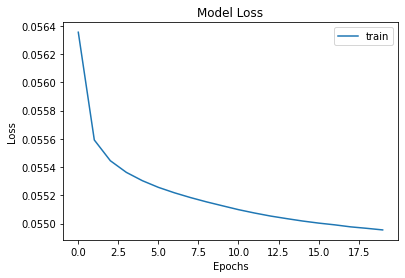

In [29]:
# Plot loss over epochs
pyplot.title('Model Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [30]:
# Make Predictions on Train
# Create empty table with 40fields
train_predict = model.predict(train_X)
train_predict_dataset_like = np.zeros(shape=(len(train_predict), 40))

# Predicted values fill table
train_predict_dataset_like[:,0] = train_predict[:,0]

# Inverse transform and then select the right field
train_predict = scaler.inverse_transform(train_predict_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict[:])))

Train Mean Absolute Error: 14.496831020097003
Train Root Mean Squared Error: 17.226258579433203


In [31]:
# Make Predictions on Test
test_predict = model.predict(test_X)
test_predict_dataset_like = np.zeros(shape=(len(test_predict), 40))

# Invert predictions
test_predict_dataset_like[:,0] = test_predict[:,0]

# Inverse transform and then select the right field
test_predict = scaler.inverse_transform(test_predict_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict[:])))

Test Mean Absolute Error: 13.573192977258673
Test Root Mean Squared Error: 15.296669671630388


In [32]:
# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

In [33]:
# Invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [34]:
# Maximum predicted metric tonnage
np.amax(inv_yhat)

137.19011

In [35]:
# Invert scaling for actual test data
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [37]:
# Maxmimum of real metric tonnage
np.amax(inv_y)

249.99

In [38]:
# Calculate RMSE
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y, inv_yhat))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y, inv_yhat))

Mean Absolute Error (MAE): 13.458157
Mean Square Error (MSE): 909.854980


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


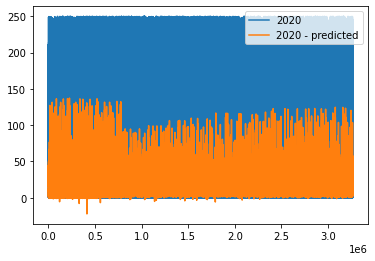

In [39]:
# Plot actual vs predicted metric tonnage
pyplot.plot(inv_y, label = '2020')
pyplot.plot(inv_yhat, label = '2020 - predicted')
pyplot.legend()
pyplot.show()